# Sentiment Classification with Word Vectors on a Feed Forward Neural Network
### Dr. Sal Barbosa, Department of Computer Science, Middle Tennessee State University

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from string import punctuation

# import Word2Vec gensim utilities
from gensim.models import KeyedVectors


### References
> Personal Notes/Projects<br>
> Book Chapters<br>
> <li>D. Jurafsky and J. Martin "Speech and Language Processing (3 Feb 2024 Draft)"</li><br>
> <li>A. Bansal "Advanced Natural Language Processing with TensorFlow 2" (Chapter 2)</li><br>
> <li>D. Rao and B. McMahan "Natural Language Processing with Pytorch" (Chapter 6)</li><br>
> Some approaches and ideas for pre-processing and training/testing were gathered from:<br>
> <li>https://github.com/bentrevett/pytorch-sentiment-analysis/blob/main/2%20-%20Recurrent%20Neural%20Networks.ipynb</li><br>
> <li>https://github.com/cezannec/CNN_Text_Classification/blob/master/CNN_Text_Classification.ipynb</li><br>

---
### Load the Data
---

In [2]:
# Data directory
DATADIR = "/home/sbarbosa/Projects/courses/6350/data/imdb/"

In [3]:
# Read data file
with open(DATADIR + "imdb_reviews.txt") as f:
    documents = [(line.strip().split('\t')[0].split(), line.strip().split('\t')[1]) for line in f]

# documents is a list of 2-tuples consisting of a list of the review's tokens and its class (negative or positive)

# Shuffle the data
#seedval = 99
#np.random.seed(seedval)
#torch.manual_seed(seedval)
np.random.shuffle(documents)

In [4]:
# Split documents into reviews and labels
reviews, labels = zip(*documents)

---
### Encode labels

As was the case in the custom logistic regression classifier, to use review labels in the neural network they must be converted from "negative" and "positive" to 0 and 1 respectively.

---

In [5]:
encoded_labels = np.array([1 if label == 'positive' else 0 for label in labels])
print(len(reviews), len(encoded_labels))
print(reviews[117][:30]) #89, 117

25000 25000
['a', 'flying', 'saucer', 'manned', 'literally', 'by', 'a', 'crew', 'of', 'about', 'male', 'space', 'explorers', 'travels', 'hundreds', 'of', 'millions', 'of', 'light', 'years', 'from', 'earth', 'to', 'check', 'in', 'on', 'a', 'colony', 'founded', 'some']


---
### Using Pre-Trained Word Embeddings (word2vec)

The 300-dimentional word2vec pre-trained embeddings (`GoogleNews-vectors-negative300-SLIM.bin`) are used in this example. However, other pre-trained vectors like <i>Glove</i> or <i>FastText</i> can easily be substituted in their place.

> Set the directory location of vectors in the `EMB_DIR` variable as shown below.

---

In [6]:
# Pre-trained embedding file location
EMB_DIR = "/home/sbarbosa/data/word-embeddings/"

# Creating the embeddings matrix
embeddings_table = KeyedVectors.load_word2vec_format(EMB_DIR+'GoogleNews-vectors-negative300-SLIM.bin', binary=True)

---
### Embeddings Matrix

The embeddings matrix in a table, are indexed by a word and contain that word's vector representation. In this example the embedding dimension is 300. The below example show the vector for the word <i>cool</i> is stored at index 512 of the lookup matrix.

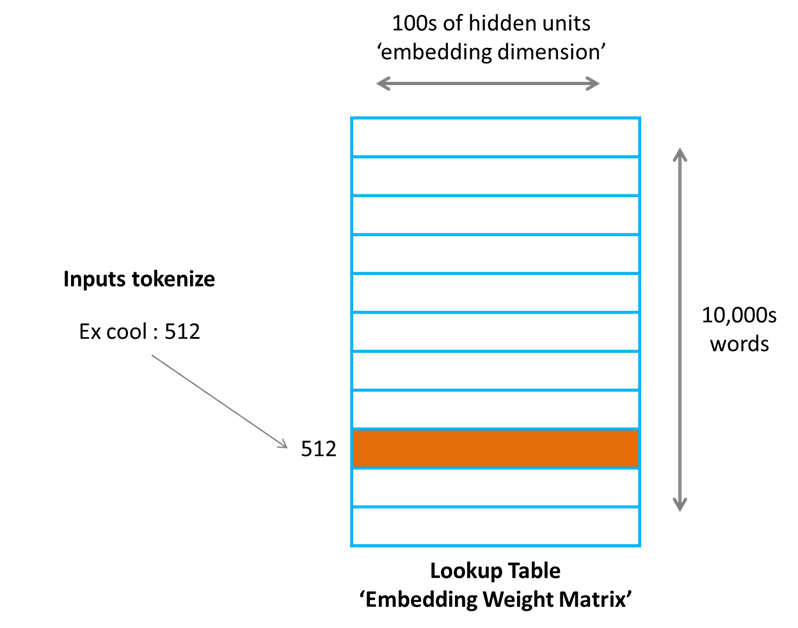

---

In [7]:
# store pretrained vocabulary
pretrained_words = []
for word in embeddings_table.index_to_key:
    pretrained_words.append(word)

In [8]:
row = 1234

# vocabulary information
print(f"Vocabulary Size: {len(pretrained_words)}\n")

# word/embedding information
word = pretrained_words[row]                  # words from index
embedding = embeddings_table[word]            # embedding for the word
print(f"Embedding Size: {len(embedding)}\n")
print(f"Word in vocab: {word}\n")
print('Associated embedding: \n', embedding)

Vocabulary Size: 299567

Embedding Size: 300

Word in vocab: human

Associated embedding: 
 [ 2.21860576e-02  3.66215259e-02  4.28219959e-02  1.12383522e-01
 -9.64948162e-02  7.55682308e-03  1.61987290e-01 -1.25947054e-02
 -1.89889409e-02  2.51894109e-02 -3.70090567e-02 -1.77294686e-02
 -9.57197621e-02 -6.27797619e-02 -2.31548809e-02  9.99825820e-02
 -1.28853526e-02  3.97217609e-02 -1.81169994e-02  5.38665839e-02
 -8.21562335e-02 -1.48036227e-01  1.74388234e-02  1.68575291e-02
  2.75145862e-02 -9.61072892e-02 -1.09283291e-01  7.75058791e-02
  8.99068192e-02 -7.55682290e-02 -9.33945850e-02 -2.20891759e-02
 -4.96037602e-02 -3.48776467e-02 -9.26195234e-02  3.81716453e-02
 -1.91827044e-02  1.80201158e-02  3.89467031e-02  2.28642337e-02
 -1.65668819e-02  8.02185833e-02 -3.58464681e-02  1.09283291e-01
 -2.51894109e-02  1.95702333e-02  1.16258813e-02  1.02307759e-01
  5.27039953e-02  2.94522326e-02  2.63519976e-02 -5.46416454e-02
 -6.89802319e-02  7.51807019e-02 -7.47931749e-02 -1.72450580e-0

---
### Converting word tokens to index values
The input to neural networks for a 64-token sequence, for example, is not 64 x embedding dimension. Instead of sending the vectors to words as input, each token's embedding matrix index is sent. The entire embedding matrix is supplied to the network at initialization. During training, when the input is received by the neural network, the translation from indexes (indices) to vectors is done in the embedding layer. The below function converts lists of tokenized reviews to index values.

---

In [9]:
# convert tokens to index values
def tokens_to_index(embeddings_table, reviews):
    indexed_reviews = [[ embeddings_table.key_to_index[review_tok] if review_tok in embeddings_table.key_to_index else 0 
                        for review_tok in review] for review in reviews]
    return indexed_reviews

In [10]:
indexed_reviews = tokens_to_index(embeddings_table, reviews)

---
### Indexing of a short review

---

In [11]:
# indexed tokens for a randomly selected short review
rev = None
while rev is None:
    rnd_idx = np.random.randint(len(reviews))
    rev = rnd_idx if len(reviews[rnd_idx]) < 50 else None

print(' '.join(reviews[rev]))
print()

for i in range(len(reviews[rev])):
    print(f"{reviews[rev][i]:<10}{indexed_reviews[rev][i]:>7}", end='\t')
    if i % 5 == 4:
        print()
print()

to quote flik that was my reaction exactly wow . . . you re perfect this is the best movie i think i can even say it s become my favorite movie ever even . wow . i tell you what wow .

to              0	quote        7554	flik            0	that            2	was             8	
my            119	reaction     3027	exactly      1836	wow         18099	.               0	
.               0	.               0	you            38	re           1195	perfect      1520	
this           25	is              3	the             9	best          189	movie        1083	
i            4365	think         144	i            4365	can            45	even          146	
say           149	it             13	s            1239	become        385	my            119	
favorite     1485	movie        1083	ever          491	even          146	.               0	
wow         18099	.               0	i            4365	tell          856	you            38	
what           78	wow         18099	.               0	


---
## Padding Reviews

Neural networks generally require that all input have the same dimensions. Movie reviews, however, have varying lengths. A maximum length of reviews must be chosen after analyzing average and maximum lengths of input as well as model constraints (architecture, memory usage, etc.). For movie review a length of at least 200 tokens works well, if memory allows. This demonstration uses 256 tokens as the maximum length. Any review longer than this is truncated (tokens beyond 256 are discarded) and shorter reviews are left padded with zeros).

The below function pads all reviews to the maximum length.

---

In [12]:
# This function pads all reviews
def pad_reviews(tokenized_reviews, max_len):

    # Get a zero tensor of the correct shape
    features = np.zeros((len(tokenized_reviews), max_len), dtype=int)

    # Go through each review and copy the indices into the features list (of padded reviews)
    for i, row in enumerate(tokenized_reviews):
        features[i, -len(row):] = np.array(row)[:max_len]
    
    return features

In [13]:
max_len = 256

features = pad_reviews(indexed_reviews, max_len=max_len)

# Check dimension lengths in resulsing data
assert len(features)==len(features), "Features must have same length as reviews."
assert len(features[0])==max_len, "Each feature row should contain max_len values."

# print first 10 indexes of the first 25 reviews 
print(features[:25,:10])
#print(len(reviews[3]), reviews[3])

[[    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [  146   433    25     8     0   101     1 24569   589    67]
 [    0     0     0     0     0     0     0     0     0     0]
 [   25 26527  3065    22    35    55     0 28696     0 84914]
 [    0     0     0     0     0    24   145   451  1011    83]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [   67     3    84    40   466  2970     0  8033  5915     0]
 [  155   595     0  2508   111     0 41910     0    40

---
## Split Data into Training, Validation, and Test

The data must be split into training and test data minimally. Many training loops can also use validation data at the end of each epoch, allowing a comparison between training and validation losses (if the latter is high or growing it may indicate overfitting).

The split for this demonstration will be 80% training (20,000 samples) and 10% each (2,500 samples) for test and validation.

---

In [14]:
# training/validation/test split (test will come from validation portion)
tt_split = int(len(features) * 0.8)

train_x, valtest_x = features[:tt_split], features[tt_split:]
train_y, valtest_y = encoded_labels[:tt_split], encoded_labels[tt_split:]

# Validation/test split (further split validation data into validation and test)
vt_split = int(len(valtest_x)*0.5)
val_x, test_x = valtest_x[:vt_split], valtest_x[vt_split:]
val_y, test_y = valtest_y[:vt_split], valtest_y[vt_split:]

## Show shapes of data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(20000, 256) 
Validation set: 	(2500, 256) 
Test set: 		(2500, 256)


## Batching and DataLoaders

Neural networks work best when data is processed in batches. This reduces convergence time through calculating and applying the average of losses and gradients of properly sized batches (compared to single input processing or full batch processing, which may not fit in memory).

PyTorch provides utilities for creating and managing batched data. The data is placed into Datasets, and Dataloaders are used to shuffle the data (if desired) and break it up into batches. This is carried out below for the traininng, validation, and test splits.

---

In [15]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 128

# shuffling and batching data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

---
### The neural network model below is a simple Feed Forward Network (FFN) neural network.
---

In [16]:
class SentimentFFN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_toks, hidden_dim, output_dim, dropout_rate, embed_model=None, freeze_embeddings=True):
                 
        super(SentimentFFN, self).__init__()

        # Class attributes
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
 
        # Embedding Layer
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)

        # If pre-trained vectors are defined, load the weights
        if embed_model is not None:
            #print("Loading pre-trained vectors")
            self.embedding.weight = nn.Parameter(torch.from_numpy(embed_model.vectors)) # all vectors
    
            # freeze embedding weights (if we're not fine-tuning them)
            if freeze_embeddings:
                #print("Freezing pre-trained vectors")
                self.embedding.requires_grad = False
        

        # Network Architecture

        # Fully connected layers
        self.layer_1 = nn.Linear(embedding_dim * num_toks, hidden_dim) 
        self.layer_2 = nn.Linear(hidden_dim, hidden_dim//2)

        # Relu activation layer
        self.relu = nn.ReLU()

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Fully connected output layer (pre-sigmoid)
        self.layer_out = nn.Linear(hidden_dim//2, output_dim) 

        # Sigmoid activation layer (produces final output)
        self.sig = nn.Sigmoid()
        
    
    def forward(self, x):
        # Convert token index values to vector embeddings
        embedded = self.embedding(x).view(x.size(0), -1)

        # Feed embeddings to first FC layer
        ff1out = self.layer_1(embedded)

        # Apply RELU to the output of FC Layer 1
        relu1out = self.relu(ff1out)

        # Feed above output to second FC Layer
        ff2out = self.layer_2(relu1out)

        # Apply RELU to the output of FC Layer 2
        relu2out = self.relu(ff2out)

        # Apply dropout
        do_out = self.dropout(relu2out)

        # Feed to last layer
        fcout = self.layer_out(do_out)
        
        # Apply the sigmoid to the ouput
        s_out = self.sig(fcout)

        # Return the final output
        return s_out


---
### Model Parameters

---

In [17]:
# General parameters
vocab_size = len(pretrained_words)
embedding_dim = len(embeddings_table[pretrained_words[0]])
print(vocab_size, embedding_dim)                                         # 300-dim vectors

299567 300


In [18]:
# FFN-specific parameters
output_dim = 1
hidden_dim = 32
dropout_rate = 0.1

# Instantiate FFN model
ffn_model = SentimentFFN(vocab_size, embedding_dim, max_len, hidden_dim, output_dim, dropout_rate, embed_model=embeddings_table, freeze_embeddings=True)


---
### Training

---

In [19]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [20]:
# Model loss and optimizer 
ffn_lr = 5e-4
ffn_criterion = nn.BCELoss()
ffn_optimizer = optim.Adam(ffn_model.parameters(), lr=ffn_lr)

In [21]:
# Move the model to the computation device (GPU or CPU)
ffn_model = ffn_model.to(device)

---
### Training Loop

---

In [22]:
# Training loop
def ffn_train(net, train_loader, epochs, print_every=100):

    # Move model to GPU/CPU
    net.to(device)

    counter = 0 # for printing
    
    # Place model in training mode
    net.train()

    # Train for some number of epochs
    for e in range(epochs):

        # batch loop
        for inputs, labels in train_loader:
            counter += 1

            # Move training data batch to GPU/CPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero out gradients
            net.zero_grad()

            # Get the output from the model
            output = net(inputs)

            # Calculate the loss
            loss = ffn_criterion(output.squeeze(), labels.float())

            # Backpropagate
            loss.backward()

            # Update weights
            ffn_optimizer.step()

            # Validation
            if counter % print_every == 0:

                # Get validation loss
                val_losses = []

                # Place model in evaluation mode (weights are not updated)
                net.eval()

                # Go through validation set
                for inputs, labels in valid_loader:

                    # Move validation data batch to GPU/CPU
                    inputs, labels = inputs.to(device), labels.to(device)
                    # get predicted label
                    output = net(inputs)

                    # Calculate validation loss
                    val_loss = ffn_criterion(output.squeeze(), labels.float())

                    # Retain for average calculation
                    val_losses.append(val_loss.item())

                # Place model back in training mode
                net.train()

                # Output losses
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Train Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))
                

In [23]:
# Clear GPU memory before training
if device == 'cuda':
    torch.cuda.empty_cache()

In [24]:
# Training parameters and invoking training
epochs = 4       # Trial and error: evaluate when validation loss stop decreasing consistently
print_every = 100
ffn_train(ffn_model, train_loader, epochs, print_every=print_every)

Epoch: 1/4... Step: 100... Train Loss: 0.638638... Val Loss: 0.627039
Epoch: 2/4... Step: 200... Train Loss: 0.213135... Val Loss: 0.333823
Epoch: 2/4... Step: 300... Train Loss: 0.262273... Val Loss: 0.308443
Epoch: 3/4... Step: 400... Train Loss: 0.086258... Val Loss: 0.329375
Epoch: 4/4... Step: 500... Train Loss: 0.028499... Val Loss: 0.351198
Epoch: 4/4... Step: 600... Train Loss: 0.079938... Val Loss: 0.399612


---
## Testing the Model

Below are examples of model testing

* **Test data performance:** Run test set through the trained model and calculate the average loss and accuracy over the  data.

* **Single Sample Inference:** Run individual example reviews not in the dataset through the model for labeling.

---

In [25]:
#Testing loop
def ffn_test(test_loader):
    # Turn off gradient calculations (saves time and compute resources)
    with torch.no_grad():
    
        # Variables for tracking losses
        test_losses = [] 
        num_correct = 0
    
        true_list = []
        pred_list = []
    
        # Place model in evaluation mode
        ffn_model.eval()
    
        # Run test data through model
        for inputs, labels in test_loader:
    
             # Move test data batch to GPU/CPU
            inputs, labels = inputs.to(device), labels.to(device)
    
            # Get predicted output
            output = ffn_model(inputs)
    
            # Calculate the loss
            test_loss = ffn_criterion(output.squeeze(), labels.float())
            test_losses.append(test_loss.item())
    
            # Convert output sigmoid probabilities to predicted classes (0 or 1)
            pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
            # Place true and predicted labels in list
            true_list += list(labels.cpu().numpy())
            pred_list += list(pred.cpu().numpy())
    
            # Compare predicted and true labels and count number of correct prediction
            correct_tensor = pred.eq(labels.float().view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if device=='cpu' else np.squeeze(correct_tensor.cpu().numpy())
            num_correct += np.sum(correct)
    
    pred_list = [a.squeeze().tolist() for a in pred_list]
    
    print(confusion_matrix(true_list, pred_list))
    print()
    print(classification_report(true_list, pred_list))
    print()
    print(f"Accuracy {accuracy_score(true_list, pred_list):.2%}")
    
    # Output average test loss
    print("Test loss: {:.3f}".format(np.mean(test_losses)))
    
    # Output average accuracy
    
    test_acc = num_correct/len(test_loader.dataset)
    print("Test accuracy: {:.3f}".format(test_acc))
    return test_acc

---
### Run the test set through the model
---

In [26]:
ffn_test(test_loader)

[[1076  159]
 [ 146 1119]]

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      1235
           1       0.88      0.88      0.88      1265

    accuracy                           0.88      2500
   macro avg       0.88      0.88      0.88      2500
weighted avg       0.88      0.88      0.88      2500


Accuracy 87.80%
Test loss: 0.365
Test accuracy: 0.878


0.878

---
### Inference on randomly selected reviews in test set
---

In [27]:
def ffn_predict(embeddings_table, net, test_review, sequence_length=max_len):

    # Place model in evaluation mode
    net.eval()
    
    # Convert tokens to index
    test_idxs = tokens_to_index(embeddings_table, test_review)
    
    # Pad tokenized sequence
    max_len=sequence_length
    features = pad_reviews(test_idxs, max_len)
    
    # Place data in tensor
    feature_tensor = torch.from_numpy(features)

    # Set the batch size
    batch_size = feature_tensor.size(0)

    # Move data to device
    feature_tensor = feature_tensor.to(device)
    
    # Get model output
    output = net(feature_tensor)
    
    # Show output value, before rounding
    print('Predicted value to be converted to 0/1: {:.6f}'.format(output.item()))
    
    # Convert sigmoid output to predicted class (0 or 1)
    pred = torch.round(output.squeeze()) 
    
    # Print label classification
    if(pred.item()==1):
        print("Review classified as Positive")
    else:
        print("Review classified as Negative")
        

---
### Results for randomly chosen reviews in the test set

---

In [28]:
pos_idx = None
neg_idx = None
idx = tt_split + vt_split

while pos_idx is None:
    i = np.random.randint(idx, len(encoded_labels))
    if encoded_labels[i] == 1:
        pos_idx = i
while neg_idx is None:
    i = np.random.randint(idx, len(encoded_labels))
    if encoded_labels[i] == 0:
        neg_idx = i
        
print(encoded_labels[pos_idx], reviews[pos_idx])
ffn_predict(embeddings_table, ffn_model, [reviews[pos_idx]], max_len)
print()
print(encoded_labels[neg_idx], reviews[neg_idx])
ffn_predict(embeddings_table, ffn_model, [reviews[neg_idx]], max_len)

1 ['the', 'film', 'notes', 'describe', 'the', 'main', 'role', 'family', 'as', 'turkish', 'immigrants', 'which', 'living', 'in', 'denmark', '.', 'however', 'it', 'is', 'so', 'clear', 'to', 'understand', 'that', 'the', 'fact', 'is', 'the', 'behavior', 'and', 'the', 'culture', 'point', 'the', 'family', 'is', 'absolute', 'kurdish', '.', 'similar', 'social', 'pressures', 'and', 'even', 'cultural', 'murders', 'keep', 'going', 'on', 'turkey', 'today', 'on', 'kurdish', 'ethnicity', 'societies', '.', 'what', 'a', 'worry', '.', '.', '.', 'br', 'br', 'it', 'is', 'widely', 'accepted', 'issue', 'in', 'turkey', 'today', 'the', 'kurdish', 'immigrants', 'living', 'in', 'european', 'countries', 'today', 'which', 'have', 'moved', 'from', 'turkey', 'at', 's', 'are', 'culturally', 'connected', 'to', 'the', 'feudal', 'moral', 'laws', 'system', 'by', 'growing', 'daughters', 'and', 'women', 'under', 'pressure', 'are', 'giving', 'harm', 'to', 'the', 'turkish', 'international', 'image', '.', 'also', 'as', 'sam

---
### Predicting the label of generic (not in dataset) positive and negative reviews

---

In [29]:
# Helper function to tokenize generic reviews not already in the data
def tokenize_generic(gen_review):
    gen_review = gen_review.lower() # place in lowercase

    # remove punctuation
    gen_text = ''.join([c for c in gen_review if c not in punctuation])

    # split on whitespace
    gen_toks = gen_text.split()
    return [gen_toks]


In [30]:
# generic negative review
gen_review_neg = "I didn't care for this movie. It was way too long and I couldn't relate to the superficial characters."

# predict generic negative review
ffn_predict(embeddings_table, ffn_model, tokenize_generic(gen_review_neg), max_len)

Predicted value to be converted to 0/1: 0.309397
Review classified as Negative


In [31]:
# generic positive review
gen_review_pos = "You should see this movie! It is filled with the fun of life during the carefree college days. It took me back ..."

ffn_predict(embeddings_table, ffn_model, tokenize_generic(gen_review_pos), max_len)

Predicted value to be converted to 0/1: 0.931770
Review classified as Positive
